In [1]:
!pip install gym

#10.1 강화학습과 DQN 기초

- agent : 플레이어
- state : agent가 활동하는 환경
- action : agent가 시행하는 상호작용
- reward : agent의 action에 따른 점수 혹은 결과

-> agent가 state에서 action을 반복하며 최고의 reward를 받는 방향으로 성장한다..

#10.2 카트폴 게임 마스터하기

- 보통 강화학습이 게임에 적용된다..
- 카트 위의 막대기가 오래 세워져 있도록 카트를 움직이는 게임..

In [6]:
import gym      #게임환경 제공
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque       #데크..양쪽에서 삽입 및 삭제 가능..
import matplotlib.pyplot as plt

##10.2.1 하이퍼파라미터

agent가 처음에는 무작위로 행동하다가 점점 경험을 학습하면서 좋은 방향으로 행동하게끔 함..

**할인계수**

- 0 ~ 1 사이의 숫자
- 0에 가까울수록 현재의 보상이 더 중요..
- 1에 가까울수록 미래의 보상도 현재의 보상만큼 중요하게 고려됨..

In [7]:
EPISODES = 50    #게임 횟수

#학습 중 에이전트가 무작위로 행동할 확률..
EPS_START = 0.9         #시작
EPS_END = 0.05          #끝

EPS_DECAY = 200     #무작위성 감소율..

GAMMA = 0.8      # 할인계수
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

##10.2.2 DQN 에이전트

- 게임을 하기 위한 신경망
- 행동을 결정하기 위한 함수
- 각 행동의 가치를 학습하는 함수

입력정보 : 카트 위치, 가트 속도, 막대기 각도, 막대기 속도

출력정보 : 좌, 우 어디로 갈지..

##10.2.3 이전 경험 기억하기

def memorize(...):

: 현재 상태, 행동, 행동에 대한 보상, 행동으로 인해 새로 생성된 상태 를 기억에 추가함..

##10.2.4 행동하기

def act(..):

- 무작위로 숫자를 골라서 특정 입실론 값보다 크면 학습한 대로 행동하고, 작으면 무작위로 행동한다..
- 학습 초기에는 학습이 의미있다고 생각하기 어렵다.. -> 입실론 값을 크게한다. (다양한 경험을 해보도록 한다..)
- 학습이 진행될수록 입실론 값을 줄여서 학습한 대로 행동할 수 있도록 한다..

**EPS_THRESHOLD**

- $
0.05 + 0.85\exp^{(-(\text{학습횟수})/200)}
$
- 0.9에서 0.05로 감소하는 함수 

##10.2.5 이전 경험으로부터 배우기

- DQN 에이전트가 기억하고 다시 상기할 수 있도록 학습시켜야 한다
- **경험 리플레이**

In [8]:
class DQNAgent:
    def __init__(self):
        #4가지 정보를 입력받아 좌, 우 어디로 갈지 결정..
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        #최적화 객체,,
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0     #학습할 때마다 증가..
        self.memory = deque(maxlen=10000)       #이전 경험의 기억을 담음.. -> 오래된 기억은 자동으로 잊음

    #기억을 추가하는 함수..
    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,  #현재 상태
                            action, #현재 상태에서의 행동
                            torch.FloatTensor([reward]),    #행동에 대한 보상
                            torch.FloatTensor([next_state])))   #행동으로 인해 새로 생성된 상태
    
    #행동하는 함수
    def act(self, state):
        #임계값 : 0.9 -> 0.05로 감소함..
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1

        #임계값보다 크면 학습한대로..
        if random.random() > eps_threshold:
            #max(1)[1]은 최댓값의 인덱스를 텐서로 반환하고, view를 조지면 [1,1]크기의 2차원 텐서가 된다.
            return self.model(state).data.max(1)[1].view(1, 1)
        #작으면 무작위로 행동
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    #경험으로 부터 배우는 함수
    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)      #무작위로 경험 가져오기
        states, actions, rewards, next_states = zip(*batch) #각 경험을 따로 묶기

        #각 경험 준비..
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)


        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

##10.2.6 학습 시작하기

In [9]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

In [ ]:
for e in range(1, EPISODES+1):
    state = env.reset()
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action.item())

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

점수 시각화..

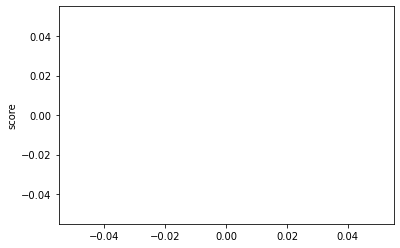

In [10]:
plt.plot(score_history)
plt.ylabel('score')
plt.show()

#10.3 마치며